In [ ]:
import os
import sys
import time
import argparse
from PIL import Image
# from generate_video import generate_video

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from torchvision.models import vgg16
from perceptual import LossNetwork
import random

import config
import myutils
from myutils import test_images_3d, test_images_2d, test_images_outp, test_metric, adjust_learning_rate, convert_to_gray
from loss import Loss
from loss import edge_conv2d
from torch.utils.data import DataLoader
from loss import L1_Charbonnier_loss
from pdb import set_trace as bp

import models
from utils import make_coord
from torch.autograd import Variable
from loss import PerceptualLoss, DCLoss

import cv2
import warnings

from dataset.GoPro_arbitrary_nosr import make_coord_3d


def double_forward(model, optimizer, preds, images, gt, device, i, epoch_id, bs):
    
    sampled_idx = sorted(random.sample(range(5), 3))
    h, w = preds[0].shape[2], preds[0].shape[3]
    for idx in range(3):
        optimizer.zero_grad()
        temp_coord = make_coord_3d((h, w), (idx + 2) / 8)
        temp_coord = [temp_coord.to(device)[None].repeat(bs, 1, 1)]
        if idx == 0:
            inputs = torch.cat([images[:, :, 1].unsqueeze(0), preds[1].detach().unsqueeze(0), preds[3].detach().unsqueeze(0), preds[5].detach().unsqueeze(0)], dim=0).permute(1, 2, 0, 3, 4)
        elif idx == 1:
            inputs = torch.cat([preds[0].detach().unsqueeze(0), preds[2].detach().unsqueeze(0), preds[4].detach().unsqueeze(0), preds[6].detach().unsqueeze(0)], dim=0).permute(1, 2, 0, 3, 4)
        else:
            inputs = torch.cat([preds[1].detach().unsqueeze(0), preds[3].detach().unsqueeze(0), preds[5].detach().unsqueeze(0), images[:, :, 2].unsqueeze(0)], dim=0).permute(1, 2, 0, 3, 4)
        new_pred_f, new_pred_b = model(inputs, temp_coord, True)
        loss = F.smooth_l1_loss(new_pred_f[0], gt[idx + 2])\
            + F.smooth_l1_loss(new_pred_b[0], gt[idx + 2])\
            + F.smooth_l1_loss(new_pred_b[0], new_pred_f[0])
        loss.backward()
        optimizer.step()
        print('Epoch %d, Iter %d, Loss: %.4f' % (epoch_id, i, loss.item()))
        
    return 
warnings.filterwarnings('ignore')

##### Tensorboard #####
writer = SummaryWriter('/output/logs')

##### Parameters #####
device_ids = [Id for Id in range(torch.cuda.device_count())]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

parser = argparse.ArgumentParser()

parser.add_argument('--data_root', type=str, default='/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/bmx-rider/')
parser.add_argument('--batch_size', type=int, default=1)
parser.add_argument('--lr', type=float, default=5e-5)
parser.add_argument('--epoch_num', type=int, default=30)
parser.add_argument('--num_workers', type=int, default=8)
parser.add_argument('--if_continue', type=bool, default=True)
parser.add_argument('--TEMP', type=float, default=1)

args = parser.parse_known_args()[0]

##### Dataset ###### 
## DAVIS 
# from dataset.Davis_liif import get_loader
# args.data_root = '/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/bmx-rider/' 
# train_loader = get_loader(args.data_root, args.batch_size, shuffle=True, num_workers=8, drop_last=True)


## VIMEO ##
# from dataset.vimeo90k_septuplet import get_loader
# args.data_root = '/data/nnice1216/vimeo_septuplet/'
# train_loader = get_loader('train', args.data_root, args.batch_size, shuffle=True, num_workers=args.num_workers)


## GOPRO ##
from dataset.GoPro_arbitrary_nosr import get_loader
random_seed = 0
interval = 5
# train_data_root = '/data/nnice1216/X4K1000FPS_dataset/train/'
train_data_root = '/data/nnice1216/high_FPS_video/GOPRO_Large_all/'
# train_data_root = '/data/nnice1216/vimeo_septuplet/'
train_loader = get_loader('train', train_data_root, args.batch_size, shuffle=True, num_workers=args.num_workers, random_seed=random_seed, seted_interval=interval)
# train_loader = get_loader('train', train_data_root, args.batch_size, shuffle=True, num_workers=args.num_workers)


##### Model #####
## LIIF ###
model_args = {'encoder_spec': {'name': 'edsr-baseline', 'args': {'no_upsampling': True}}, 'imnet_spec': {'name': 'mlp', 'args': {'out_dim': 3, 'hidden_list': [64, 64]}}}
model_spec = {'name': 'liif_optical', 'args': model_args}
model = models.make(model_spec).to(device)
model = nn.DataParallel(model, device_ids=device_ids)
# for k, v in model.named_parameters():
#     if k[:14] == 'module.encoder':
#         v.requires_grad=False
        
# model.load_state_dict(torch.load('/model/nnice1216/video/FLAVR_2x.pth')['state_dict'], strict=False)

if args.if_continue:
    name = 'temp-153.pth'
#     name = 'vimeo_epoch1_iter499.pth'
    print('Load model ' + name)
    model.load_state_dict(torch.load('/model/nnice1216/video/' + name))

##### Loss & Optimizer #####
# optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

##### Training #####
model.train()
loss_f = PerceptualLoss(nn.MSELoss(reduce=True))
index = 0
# test_metric(model, 0, 0)
        
for epoch_id in range(args.epoch_num):
    
    print('Epoch {} Begin'.format(epoch_id))
    lr = adjust_learning_rate(epoch_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    out_dir = '/output/models/'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    out_dir2 = '/output/tempimgs22/'
    if not os.path.exists(out_dir2):
        os.makedirs(out_dir2)

    for i, data in enumerate(train_loader):
        
        ## VIMEO PRE_PROCESS FOR LIIF_3D ##
        # images, gt_image, coords, cells, times = data
        images, gt_image, coords, _, _ = data
        images = [img_.to(device) for img_ in images]
        images = torch.stack(images, dim=2)
        gt = [g_.to(device) for g_ in gt_image]
        # gt = [g_.view(args.batch_size, 3, -1).permute(0, 2, 1).to(device) for g_ in gt_image]
        # gt = torch.cat(gt).view(args.batch_size, 3, -1).permute(0, 2, 1)
        coords = [c_.to(device) for c_ in coords]
        # coord, cell = coord.to(device), cell.to(device)
 
        # Forward
        optimizer.zero_grad()
        # pred_inter, pred_0, pred_1 = model(img, coord, cell)
        # bp()
        
        preds_f, masks, flows = model(images, coords, True)
        
        loss1 = 0
        loss2 = 0
        loss3 = 0
        loss4 = 0
        
        for idx in range(3):
#             diff = torch.abs(warps[idx] - convert_to_gray(gt[idx]))
#             diff = (diff - diff.min()) / (diff.max() - diff.min())
            loss1 += F.smooth_l1_loss(preds_f[idx], gt[idx])
            loss4 += F.smooth_l1_loss(masks[idx], flows[idx])
            # loss1 += (F.smooth_l1_loss(preds_f[idx], gt[idx], reduce=False) * (att_map1[idx].unsqueeze(1) + 1)).mean()
            loss2 += loss_f.get_loss(preds_f[idx], gt[idx]) * 0.05
            # loss3 += loss_f.get_loss(preds_f[idx] * ((att_map1[idx].unsqueeze(1)) / 2), gt[idx] * ((att_map1[idx].unsqueeze(1)) / 2)) * 0.05
        
        # Backward & Update
        loss = loss1 + loss2 + loss3 + loss4
        loss.backward()
        optimizer.step()
        
        print('Epoch %d, Iter %d, Loss: %.4f' % (epoch_id, i, loss.item()))
        print('Loss1: %.4f, Loss2: %.4f, Loss4: %.4f' % (loss1.item(), loss2.item(), loss4.item()))
        # print('Loss1: %.4f, Loss2: %.4f, Loss3: %.4f' % (loss1.item(), loss2.item(), loss3.item()))
        # print('Epoch %d, Iter %d, Loss1: %.4f, Loss2: %.4f, Loss: %.4f' % (epoch_id, i, loss1.item(), loss2.item(), loss.item()))
        writer.add_scalar('Training Loss', loss.item(), index)
        writer.add_scalar('L1 Loss', loss1.item(), index)
        # writer.add_scalar('Perceptual Loss', loss2.item(), index)
        index += 1
        # index += 1
        
        if i % 25 == 0:
            Image.fromarray((gt_image[0][0].permute(1, 2, 0).numpy() * 255).astype(np.uint8)).save(os.path.join(out_dir2, 'Epoch{}_iter{}_GT.jpg'.format(epoch_id, i)))
            Image.fromarray((preds_f[0][0].permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy() * 255).astype(np.uint8)).save(os.path.join(out_dir2, 'Epoch{}_iter{}_PRED.jpg'.format(epoch_id, i)))
            Image.fromarray((flows[0][0, 0].clamp(0, 1).detach().cpu().numpy() * 255).astype(np.uint8)).save(os.path.join(out_dir2, 'Epoch{}_iter{}_MASKGT.jpg'.format(epoch_id, i)))
            Image.fromarray((masks[0][0, 0].clamp(0, 1).detach().cpu().numpy() * 255).astype(np.uint8)).save(os.path.join(out_dir2, 'Epoch{}_iter{}_MASK.jpg'.format(epoch_id, i)))
#             Image.fromarray((masks[0][0][0].clamp(0, 1).detach().cpu().numpy() * 255).astype(np.uint8)).save(os.path.join(out_dir2, 'Epoch{}_iter{}_MASK.jpg'.format(epoch_id, i)))
#             diff = torch.abs(warps[idx] - convert_to_gray(gt[idx]))
#             diff = (diff - diff.min()) / (diff.max() - diff.min())
#             img = (diff.clamp(0, 1).detach().cpu() * 255)[0, 0].numpy().astype(np.uint8)
#             Image.fromarray(img).save(os.path.join(out_dir2, 'Epoch{}_iter{}_MASK_GT.jpg'.format(epoch_id, i)))
            
        # if i == 50:
        #     test_metric(model, epoch_id, i, True)
        
        if i % 100 == 0:
            test_images_outp(model, device, 1 / 64, epoch_id, i)
        if i % 100 == 1:
            test_images_outp(model, device, 11 / 64, epoch_id, i)
        if i % 100 == 2:
            test_images_outp(model, device, 23 / 64, epoch_id, i)
        elif i % 100 == 4:
            test_images_outp(model, device, 32 / 64, epoch_id, i)
        elif i % 100 == 6:
            test_images_outp(model, device, 43 / 64, epoch_id, i)
        elif i % 100 == 8:
            test_images_outp(model, device, 52 / 64, epoch_id, i)
        elif i % 100 == 9:
            test_images_outp(model, device, 63 / 64, epoch_id, i)
            # out_path = '/output/Image22s/Epoch_{}'.format(epoch_id)
            # Image.open('/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/bmx-rider/00003.jpg').resize((720, 416)).save(os.path.join(out_path, 'Iter{}.jpg'.format(i)))
            # test_images_outp(model, device, 7 / 8, epoch_id, i)
            # test_images_3d(model, device, 7 / 8, epoch_id, i)
            
        model.train()
        # double_forward(model, optimizer, preds_f, images, gt, device, i, epoch_id, args.batch_size)
        
        if (i + 1) % 100 == 0:
            torch.save(model.state_dict(), '/output/models/vimeo_epoch{}_iter{}.pth'.format(epoch_id, i))
        if (i + 1) % 1000 == 0:
            test_metric(model, epoch_id, i)
    # if epoch_id % 7 == 6:
    #     test_metric(model, epoch_id, i)
    print("Epoch {} Done. Index={}".format(epoch_id, index))

In [ ]:
import torch.autograd as ag
ag.function

In [1]:
import torch
input = torch.rand(4, 65536, 2).cuda()
target = torch.rand(4, 65536, 2).cuda()
torch.cdist(input, target).shape

RuntimeError: CUDA out of memory. Tried to allocate 64.00 GiB (GPU 0; 10.92 GiB total capacity; 4.00 MiB already allocated; 10.42 GiB free; 16.00 MiB cached)

In [1]:
import torch
dict1 = torch.load('/model/nnice1216/video/checkpoints/Stage3_RCSN_RQFP/Stage3_checkpoint.ckpt')

In [4]:
x = torch.randn(3, 2)
y = torch.ones(3, 2)
torch.where(x > 0.5, y, y)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

In [13]:
# %%export PYTHONPATH=$PYTHONPATH:$(pwd)
%cd MinDepthFlowProjection
!rm -rf build *.egg-info dist
%python setup.py install
%cd ..

[Errno 2] No such file or directory: 'MinDepthFlowProjection'
/code/FLAVR-main/my_package/MinDepthFlowProjection


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [6]:
import torchvision.transforms as tfs
img = Image.open('/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/bmx-rider/00002.jpg')
img.size

NameError: name 'Image' is not defined

In [2]:
15//2

7

In [4]:
def warpgrid(tenInput, tenFlow):
    backwarp_tenGrid = make_coord_2d((tenInput.shape[3], tenInput.shape[2]))

    tenFlow = torch.cat([tenFlow[:, 0:1, :, :] / ((tenInput.shape[3] - 1.0) / 2.0),
                         tenFlow[:, 1:2, :, :] / ((tenInput.shape[2] - 1.0) / 2.0)], 1)
    
    g = (backwarp_tenGrid + tenFlow).permute(0, 2, 3, 1)
    return g, backwarp_tenGrid.permute(0, 2, 3, 1)


def make_coord_2d(shape, ranges=None, flatten=False):
    """ Make coordinates at grid centers.
    """
    coord_seqs = []
    for i, n in enumerate(shape):
        if ranges is None:
            v0, v1 = -1, 1
        else:
            v0, v1 = ranges[i]
        r = (v1 - v0) / (2 * n)
        seq = v0 + r + (2 * r) * torch.arange(n).float()
        coord_seqs.append(seq)
    ret = torch.stack(torch.meshgrid(*coord_seqs), dim=-1)
    if flatten:
        ret = ret.view(-1, ret.shape[-1])
    return ret

In [5]:
input_t = torch.rand((4, 3, 256, 512))
input_f = torch.rand((4, 2, 256, 512))

In [6]:
backwarp_tenGrid = make_coord_2d((input_t.shape[2], input_t.shape[3]))

In [10]:
backwarp_tenGrid.unsqueeze(0).repeat(input_f.shape[0], 1, 1, 1).shape

torch.Size([4, 256, 512, 2])

In [12]:
tenFlow = torch.cat([input_f[:, 0:1, :, :] / ((input_t.shape[3] - 1.0) / 2.0),
                         input_f[:, 1:2, :, :] / ((input_t.shape[2] - 1.0) / 2.0)], 1)

In [13]:
tenFlow.permute(0, 2, 3, 1).shape

torch.Size([4, 256, 512, 2])

In [75]:
tenHorizontal = torch.linspace(-1.0, 1.0, input_f.shape[3], device=device).view(
            1, 1, 1, input_f.shape[3]).expand(input_f.shape[0], -1, input_f.shape[2], -1)
tenVertical = torch.linspace(-1.0, 1.0, input_f.shape[2], device=device).view(
            1, 1, input_f.shape[2], 1).expand(input_f.shape[0], -1, -1, input_f.shape[3])
backwarp_tenGrid_2 = torch.cat(
            [tenHorizontal, tenVertical], 1).to(device)

In [61]:
# backwarp_tenGrid = make_coord_2d((input_t.shape[2], input_t.shape[3]))
b = backwarp_tenGrid_2[0].permute(1, 2, 0).flip(-1)
b[:, :, 0][b[:, :, 0] <= 0] += 0.004
b[:, :, 0][b[:, :, 0] > 0] -= 0.004
b[:, :, 1][b[:, :, 1] <= 0] += 0.002
b[:, :, 1][b[:, :, 1] > 0] -= 0.002

In [86]:
(backwarp_tenGrid_2[1] == backwarp_tenGrid_2[0]).min()

tensor(True, device='cuda:0')

In [50]:
backwarp_tenGrid

tensor([[[-0.9961, -0.9980],
         [-0.9961, -0.9941],
         [-0.9961, -0.9902],
         ...,
         [-0.9961,  0.9902],
         [-0.9961,  0.9941],
         [-0.9961,  0.9980]],

        [[-0.9883, -0.9980],
         [-0.9883, -0.9941],
         [-0.9883, -0.9902],
         ...,
         [-0.9883,  0.9902],
         [-0.9883,  0.9941],
         [-0.9883,  0.9980]],

        [[-0.9805, -0.9980],
         [-0.9805, -0.9941],
         [-0.9805, -0.9902],
         ...,
         [-0.9805,  0.9902],
         [-0.9805,  0.9941],
         [-0.9805,  0.9980]],

        ...,

        [[ 0.9805, -0.9980],
         [ 0.9805, -0.9941],
         [ 0.9805, -0.9902],
         ...,
         [ 0.9805,  0.9902],
         [ 0.9805,  0.9941],
         [ 0.9805,  0.9980]],

        [[ 0.9883, -0.9980],
         [ 0.9883, -0.9941],
         [ 0.9883, -0.9902],
         ...,
         [ 0.9883,  0.9902],
         [ 0.9883,  0.9941],
         [ 0.9883,  0.9980]],

        [[ 0.9961, -0.9980],
       

In [62]:
(b.cpu() - backwarp_tenGrid).max()

tensor(0.0040)

In [1]:
import torch

In [2]:
a = torch.rand((2, 64, 256, 256))
b = torch.rand((2, 64, 256, 256))

In [9]:
a[a > 0.5] = 2
a.max()

tensor(2.)

In [10]:
a

tensor([[[[2.0000e+00, 1.4005e-01, 2.4314e-01,  ..., 2.0000e+00,
           4.8413e-01, 2.0000e+00],
          [2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 4.6476e-01,
           2.0000e+00, 9.5936e-02],
          [4.5191e-01, 2.7507e-01, 2.0000e+00,  ..., 1.5541e-01,
           2.0000e+00, 2.0000e+00],
          ...,
          [2.0000e+00, 8.8703e-02, 3.6379e-01,  ..., 2.0000e+00,
           3.8566e-01, 2.0000e+00],
          [4.0229e-01, 2.0000e+00, 2.0000e+00,  ..., 4.2831e-02,
           2.0000e+00, 9.1949e-02],
          [3.2624e-01, 1.8284e-01, 2.4027e-01,  ..., 7.4036e-02,
           4.6509e-01, 2.0000e+00]],

         [[2.0000e+00, 3.7825e-01, 2.0000e+00,  ..., 2.0000e+00,
           2.0000e+00, 4.7808e-01],
          [2.0000e+00, 2.6022e-01, 2.0000e+00,  ..., 2.9750e-01,
           2.0000e+00, 2.3356e-01],
          [2.3864e-01, 4.9891e-01, 2.0000e+00,  ..., 2.4213e-01,
           4.1245e-02, 3.3658e-01],
          ...,
          [3.9069e-01, 3.8783e-01, 2.0000e+00,  ..., 8.2205

In [1]:
from PIL import Image
from edge_loss import canny
import torchvision.transforms as tfs
import torch
import numpy as np
img1 = Image.open('/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/bmx-rider/00002.jpg')
img2 = Image.open('/data/nnice1216/vimeo_septuplet/DAVIS/JPEGImages/Full-Resolution/bmx-rider/00003.jpg')
img_t1 = tfs.ToTensor()(img1)[None]
img_t2 = tfs.ToTensor()(img2)[None]
img_t = torch.cat([img_t1, img_t2])
print(img_t.shape)
print(torch.cat([img_t1]).shape)
print(img_t1.shape)

torch.Size([2, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])
torch.Size([1, 3, 1080, 1920])


In [2]:
g, t1, t2, t3 = canny(img_t1, t=10)

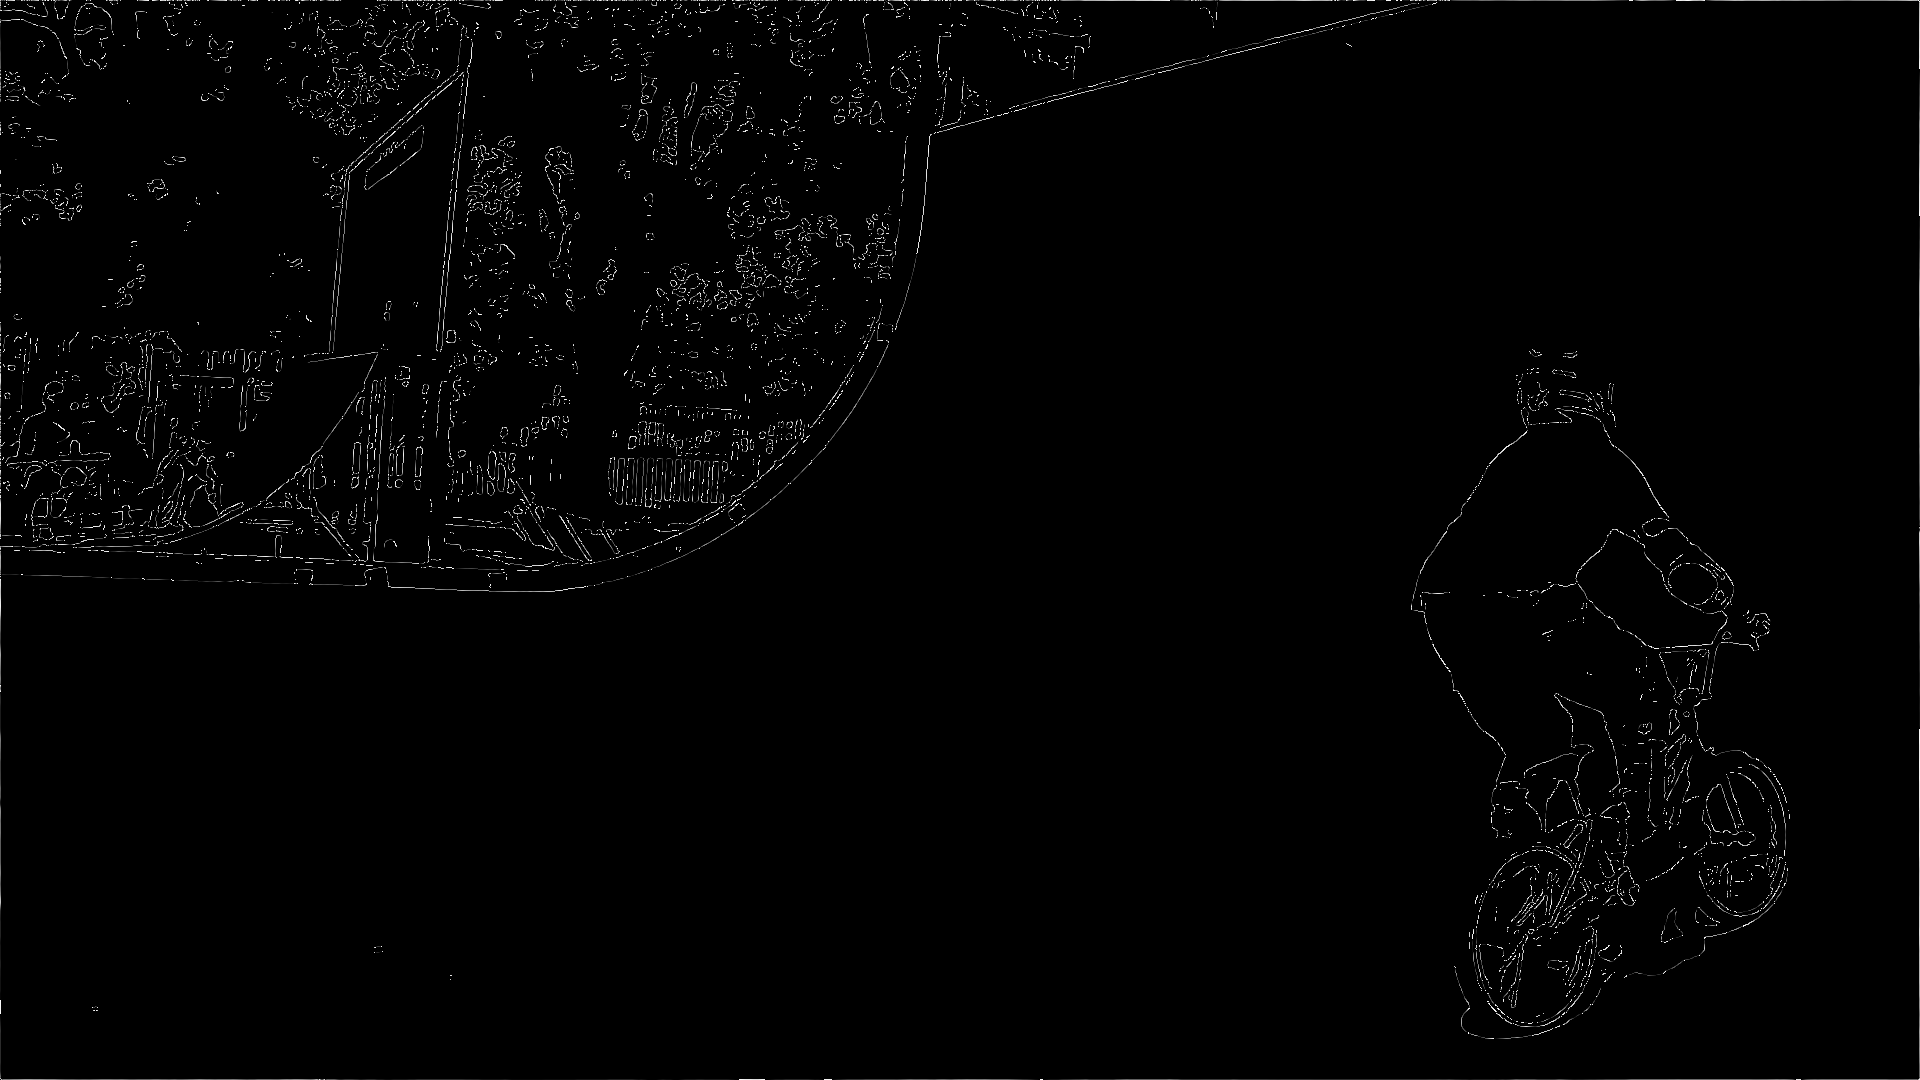

In [3]:
Image.fromarray((t2[0][0].cpu().detach().numpy() * 45).astype(np.uint8))

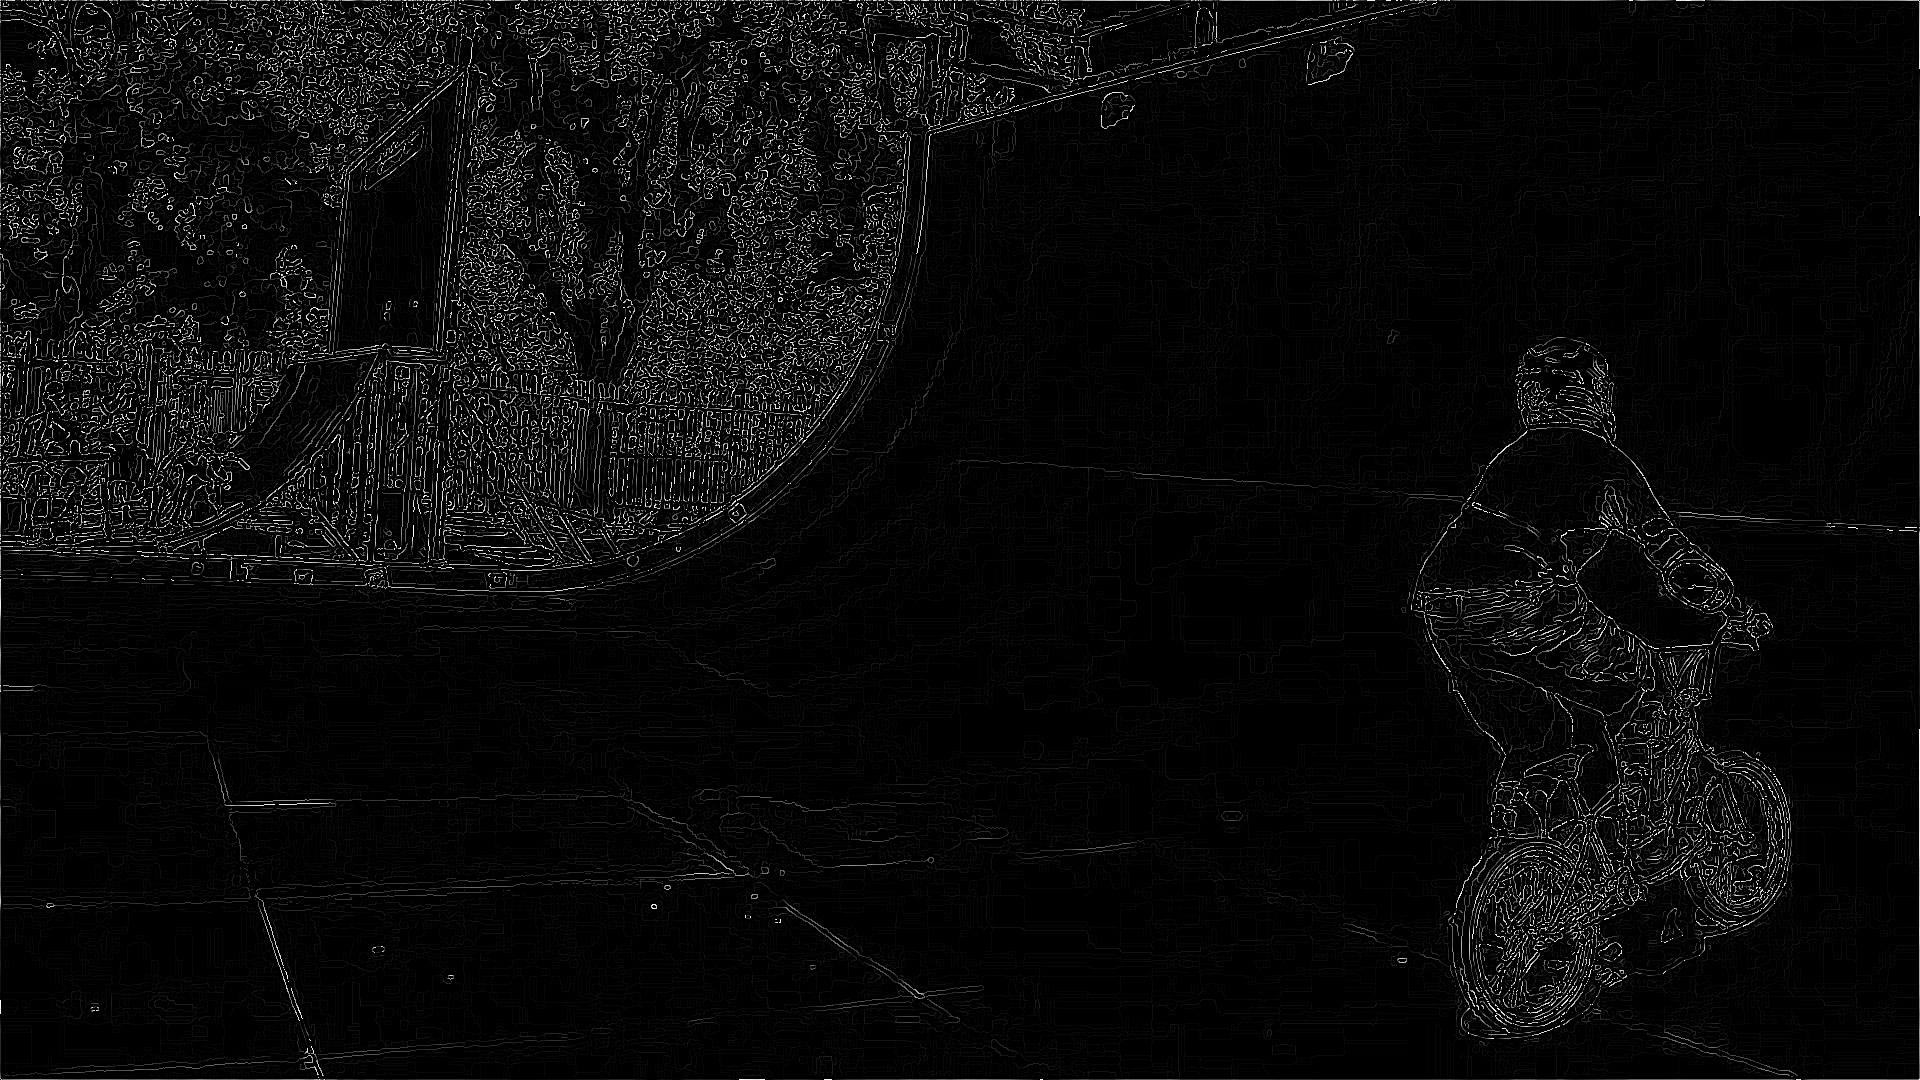

In [4]:
Image.fromarray((t1[0][0].cpu().detach().numpy() * 45).astype(np.uint8))

In [1]:
from models.adacofnet import AdaCoFNet
model = AdaCoFNet()

In [4]:
import torch
model.load_state_dict(torch.load('/model/nnice1216/video/checkpoint/kernelsize_5/ckpt.pth')['state_dict'])

<All keys matched successfully>

In [2]:
from models.DAIN import DAIN
import torch

In [3]:
model = DAIN()
model.load_state_dict(torch.load('/model/nnice1216/video/best.pth'))

<All keys matched successfully>

In [4]:
model.rectifyNet

MultipleBasicBlock(
  (block1): Sequential(
    (0): Conv2d(437, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (block4): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (block5): Sequential(
    (0): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
import torch
import torch.nn as nn

# git clone https://github.com/rtqichen/torchdiffeq.git
from torchdiffeq import odeint as odeint


class DiffeqSolver(nn.Module):
    def __init__(self, input_dim, ode_func, method, latents,
                 odeint_rtol=1e-4, odeint_atol=1e-5, device=torch.device("cpu")):
        super(DiffeqSolver, self).__init__()

        self.ode_method = method
        self.latents = latents
        self.device = device
        self.ode_func = ode_func

        self.odeint_rtol = odeint_rtol
        self.odeint_atol = odeint_atol

    def forward(self, first_point, time_steps_to_predict, backwards=False):
        """
        # Decode the trajectory through ODE Solver
        """
        # n_traj_samples, n_traj = first_point.size()[0], first_point.size()[1]

        pred_y = odeint(self.ode_func, first_point, time_steps_to_predict,
                        rtol=self.odeint_rtol, atol=self.odeint_atol, method=self.ode_method)
        pred_y = pred_y.permute(1, 0, 2, 3, 4)  # => [b, t, c, h0, w0]


        return pred_y

    def sample_traj_from_prior(self, starting_point_enc, time_steps_to_predict, n_traj_samples=1):
        """
        # Decode the trajectory through ODE Solver using samples from the prior

        time_steps_to_predict: time steps at which we want to sample the new trajectory
        """
        func = self.ode_func.sample_next_point_from_prior

        pred_y = odeint(func, starting_point_enc, time_steps_to_predict,
                        rtol=self.odeint_rtol, atol=self.odeint_atol, method=self.ode_method)
        pred_y = pred_y.permute(1, 2, 0, 3)
        return pred_y


#####################################################################################################

class ODEFunc(nn.Module):
    def __init__(self, opt, input_dim, latent_dim, ode_func_net, device=torch.device("cpu")):
        """
        input_dim: dimensionality of the input
        latent_dim: dimensionality used for ODE. Analog of a continous latent state
        """
        super(ODEFunc, self).__init__()

        self.input_dim = input_dim
        self.device = device
        self.opt = opt

        self.gradient_net = ode_func_net

    def forward(self, t_local, y, backwards=False):
        """
        Perform one step in solving ODE. Given current data point y and current time point t_local, returns gradient dy/dt at this time point
        t_local: current time point
        y: value at the current time point
        """
        grad = self.get_ode_gradient_nn(t_local, y)
        if backwards:
            grad = -grad
        return grad

    def get_ode_gradient_nn(self, t_local, y):
        output = self.gradient_net(y)
        return output

    def sample_next_point_from_prior(self, t_local, y):
        """
        t_local: current time point
        y: value at the current time point
        """
        return self.get_ode_gradient_nn(t_local, y)
